In [8]:
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [4]:
datafile = "./daily-min-temperatures.csv"
with open(datafile) as csvfile:
    print(f"Header looks like this: \n\n{csvfile.readline()}")
    print(f"First data looks like this: \n\n{csvfile.readline()}")
    print(f"Second data looks like this: \n\n{csvfile.readline()}")


Header looks like this: 

"Date","Temp"

First data looks like this: 

"1981-01-01",20.7

Second data looks like this: 

"1981-01-02",17.9



In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [6]:
def parse_data_from_file(filename):
    times = []
    temperatures = []

    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')

        # skip header
        next(reader)

        i = 0
        for row in reader:
            times.append(i)
            temperatures.append(float(row[1]))
            i += 1

    return times, temperatures

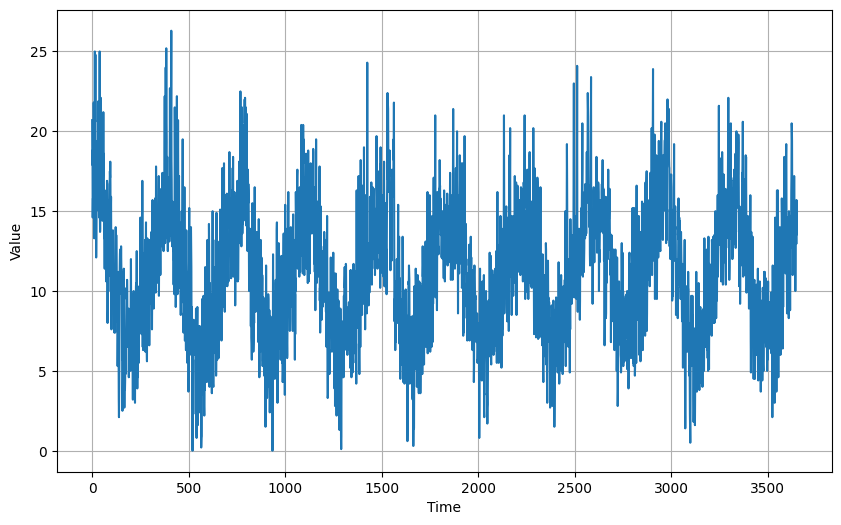

In [9]:
@dataclass
class G:
    TEMPERATURES_CSV = './daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 256
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [10]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [12]:
def windowed_dataset(series,
                     window_size=G.WINDOW_SIZE,
                     batch_size=G.BATCH_SIZE,
                     shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

2022-11-16 19:22:18.246682: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1,
                               activation="relu", padding="causal",
                               input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    return model

In [14]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


In [17]:
def adjust_learning_rate(dataset):
    model = create_uncompiled_model()
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-4 * 10 ** (epoch // 20)
    )

    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
    return history

In [18]:
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
10/10 [==============================] - 5s 163ms/step - loss: 10.3739 - mae: 10.8732 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - 2s 154ms/step - loss: 10.2822 - mae: 10.7814 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - 2s 152ms/step - loss: 10.2511 - mae: 10.7501 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - 2s 153ms/step - loss: 10.2388 - mae: 10.7378 - lr: 1.0000e-04
Epoch 5/100
10/10 [==============================] - 2s 160ms/step - loss: 10.2285 - mae: 10.7275 - lr: 1.0000e-04
Epoch 6/100
10/10 [==============================] - 2s 162ms/step - loss: 10.2184 - mae: 10.7174 - lr: 1.0000e-04
Epoch 7/100
10/10 [==============================] - 2s 161ms/step - loss: 10.2084 - mae: 10.7073 - lr: 1.0000e-04
Epoch 8/100
10/10 [==============================] - 2s 159ms/step - loss: 10.1985 - mae: 10.6974 - lr: 1.0000e-04
Epoch 9/100
10/10 [==============================] - 2s 157ms/step - loss: 10.18

(1e-08, 0.001, 0.0, 15.0)

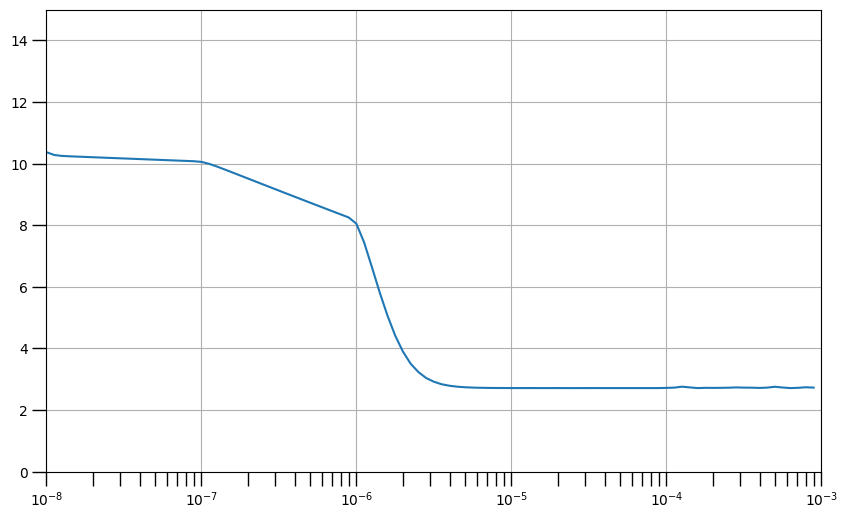

In [21]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, lr_history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 15])

(0.0001, 10.0, 0.0, 10.0)

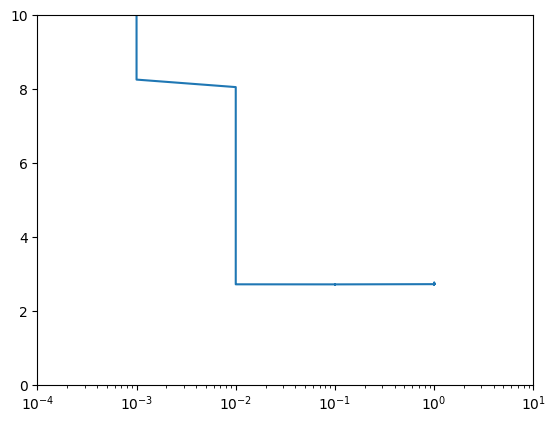

In [19]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

In [22]:
 def create_model():
    model = create_uncompiled_model()
    learning_rate = 3e-6
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
                  metrics=["mae"])
    return model

In [23]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
10/10 [==============================] - 4s 154ms/step - loss: 10.3084 - mae: 10.8075
Epoch 2/50
10/10 [==============================] - 2s 153ms/step - loss: 10.3070 - mae: 10.8061
Epoch 3/50
10/10 [==============================] - 2s 153ms/step - loss: 10.3050 - mae: 10.8041
Epoch 4/50
10/10 [==============================] - 2s 156ms/step - loss: 10.3028 - mae: 10.8018
Epoch 5/50
10/10 [==============================] - 2s 163ms/step - loss: 10.3004 - mae: 10.7995
Epoch 6/50
10/10 [==============================] - 2s 157ms/step - loss: 10.2979 - mae: 10.7970
Epoch 7/50
10/10 [==============================] - 2s 151ms/step - loss: 10.2954 - mae: 10.7944
Epoch 8/50
10/10 [==============================] - 2s 155ms/step - loss: 10.2927 - mae: 10.7918
Epoch 9/50
10/10 [==============================] - 2s 199ms/step - loss: 10.2900 - mae: 10.7891
Epoch 10/50
10/10 [==============================] - 2s 192ms/step - loss: 10.2873 - mae: 10.7864
Epoch 11/50
10/10 [==========

In [24]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [25]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

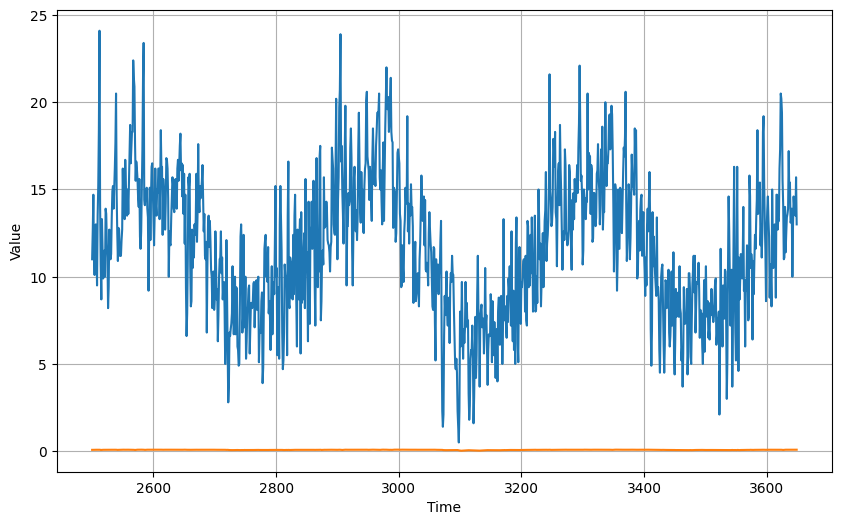

In [26]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]


# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [27]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 150.73, mae: 11.62 for forecast
